# ESG - Index calculating

In [17]:
% matplotlib inline
import os

import pandas as pd
from matplotlib import pyplot as plt

UsageError: Line magic function `%` not found.


### Methods used in analysis

In [2]:
def destym(series):
    series = series * -1
    return series


def ważenie(wagi, series, key):
    try:
        series = series * wagi[key]
        return series
    except:
        return series

## 1. Loading the necessary data

In [3]:
wd = "Sentymenty\\"

In [4]:
a = []
for filename in os.listdir(wd):
    a.append(filename)
print(a)
b = ["tw_env", "indead", "news_ceo", "sent_cyb", "sen_env", "sen_gov", "tw_soc"]

dicts = dict(zip(a, b))

NameError: name 'os' is not defined

In [5]:
to_dicts = pd.read_excel("ESG_cops.xlsx", engine='openpyxl')

to_dicts = to_dicts.set_index("Name")

d_take = to_dicts["Refinitiv"]
d_take = pd.concat([d_take, to_dicts["Twitter"].rename("Refinitiv")], axis=0)
d_take = pd.concat([d_take, to_dicts["Indeed"].rename("Refinitiv")], axis=0)
d_take = pd.concat([d_take, to_dicts["Guardian"].rename("Refinitiv")], axis=0)

d_g = d_take.reset_index()

d = pd.DataFrame(d_take)

d = d.reset_index()
p = d["Name"].tolist()
dr = d["Refinitiv"].tolist()
mapper = dict(zip(dr, p))

NameError: name 'pd' is not defined

In [7]:
to_dicts.columns

NameError: name 'to_dicts' is not defined

In [8]:
df_gl = pd.DataFrame()
for filename in os.listdir(wd):
    if filename.endswith("xlsx"):
        df_1 = pd.read_excel(wd + filename, index_col=[0, 1], engine='openpyxl')
        df_1 = df_1.reset_index()
        df_1["company"] = df_1["company"].map(mapper)
        df_1 = df_1.groupby(['company', 'period']).agg({"negative": "sum", "positive": "sum", "neutral": "sum"})
        df_1["pos_perc"] = df_1["positive"] / (df_1["positive"] + df_1["neutral"] + df_1["negative"])
        df_1["neg_perc"] = df_1["negative"] / (df_1["positive"] + df_1["neutral"] + df_1["negative"])
        df_1.columns = ["{}_{}".format(x, dicts[filename]) for x in df_1.columns]
        df_1 = df_1.reset_index()
        if df_gl.empty:
            df_gl = df_1
        else:
            df_gl = df_gl.merge(df_1, how="outer", on=["company", "period"])

df_gl = df_gl.drop_duplicates()

df_gl.to_excel("dane_merged.xlsx")

NameError: name 'pd' is not defined

In [9]:
df_col = ['company', 'period', 'pos_perc_tw_env', 'neg_perc_tw_env', 'pos_perc_indead',
          'neg_perc_indead', 'pos_perc_news_ceo', 'neg_perc_news_ceo', 'pos_perc_sent_cyb', 'neg_perc_sent_cyb',
          'pos_perc_sen_env', 'neg_perc_sen_env', 'pos_perc_sen_gov', 'neg_perc_sen_gov', 'pos_perc_tw_soc',
          'neg_perc_tw_soc']

df_sco = df_gl[df_col]

df_sco.to_excel("zmienne.xlsx")

NameError: name 'df_gl' is not defined

In [10]:
df_dest = pd.DataFrame([destym(df_sco[i]) if i.startswith("neg_") else df_sco[i] for i in df_sco.columns]).T

df_dest = df_dest.fillna(0)

NameError: name 'pd' is not defined

In [11]:
wagi = {'pos_perc_tw_env': 0.05, 'neg_perc_tw_env': 0.05, 'pos_perc_indead': 0.1,
        'neg_perc_indead': 0.1, 'pos_perc_news_ceo': 0.25, 'neg_perc_news_ceo': 0.25,
        'pos_perc_sent_cyb': 0.35, 'neg_perc_sent_cyb': 0.35, 'pos_perc_sen_env': 0.35,
        'neg_perc_sen_env': 0.55, 'pos_perc_sen_gov': 0.25, 'neg_perc_sen_gov': 0.25,
        'pos_perc_tw_soc': 0.05, 'neg_perc_tw_soc': 0.05}

In [12]:
zwazony = pd.DataFrame([ważenie(wagi, df_dest[i], i) for i in df_sco.columns]).T

NameError: name 'pd' is not defined

In [13]:
wagi_agg = zwazony[["company", "period"]]
wagi_agg["env"] = zwazony[['pos_perc_tw_env', 'neg_perc_tw_env', 'pos_perc_sen_env', 'neg_perc_sen_env']].sum(axis=1)
wagi_agg["soc"] = zwazony[
    ['pos_perc_indead', 'neg_perc_indead', 'pos_perc_sent_cyb', 'neg_perc_sent_cyb', 'pos_perc_tw_soc',
     'neg_perc_tw_soc']].sum(axis=1)
wagi_agg["gov"] = zwazony[['pos_perc_news_ceo', 'neg_perc_news_ceo', 'pos_perc_sen_gov', 'neg_perc_sen_gov']].sum(
    axis=1)
wagi_agg["all"] = wagi_agg["env"] * 0.4 + wagi_agg["soc"] * 0.3 + wagi_agg["gov"] * 0.2
wagi_agg["all"] = wagi_agg["all"] * 100
wagi_agg["period"] = pd.to_datetime(wagi_agg["period"], format="%Y-%m")
wagi_agg["year"] = wagi_agg["period"].dt.year
wagi_agg = wagi_agg.merge(to_dicts[["Type"]], how="inner", left_on="company", right_on="Name")

wagi_agg.to_excel("model_m.xlsx")

NameError: name 'zwazony' is not defined

In [14]:
waga = wagi_agg.groupby(["company", "year", "Type"]).agg({"all": "mean"})
waga = waga.reset_index()

waga = waga[waga["year"] == 2020]
waga = waga.set_index(["company", "year"])

ref_sc = pd.read_csv("ESG_Scores.csv")

ref_sc["company"] = ref_sc["Instrument"].map(mapper)

ref_sc = ref_sc.fillna("BP")

ref_sc = ref_sc.set_index(["company", "year"])
waga = waga.merge(ref_sc[["ESG Score", "ESG Score Grade"]], how="outer", on=["year", "company"])

waga["score_combined"] = waga["ESG Score"] * 0.8 + waga["all"] * 0.2

waga.to_excel("compare.xlsx")

NameError: name 'wagi_agg' is not defined

In [15]:
import seaborn as sns

In [16]:
sns.lineplot(x='period', y='all', hue="company", data=wagi_agg[wagi_agg["Type"] == "Automobiles"])
plt.xlabel("Date")
plt.ylabel("%")
plt.title("Yearly change of ESG_NLP Score for Automobiles company")
plt.legend()
plt.show()

NameError: name 'wagi_agg' is not defined

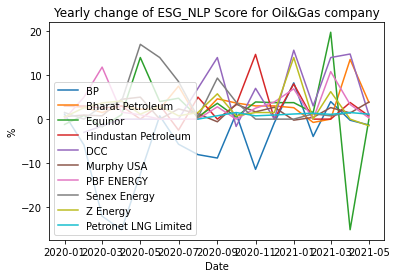

In [374]:
sns.lineplot(x='period', y='all', hue="company", data=wagi_agg[wagi_agg["Type"] == "Oil & Gas"])
plt.xlabel("Date")
plt.ylabel("%")
plt.title("Yearly change of ESG_NLP Score for Oil&Gas company")
plt.legend()
plt.show()